In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from invisible_cities.core.core_functions  import shift_to_bin_centers
from invisible_cities.core                 import fit_functions as fitf

In [2]:
def hist(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    create_new_figure(kwargs)

    y, x, p = plt.hist(*args, **kwargs)
    return y, shift_to_bin_centers(x), p


def hist2d(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    create_new_figure(kwargs)

    z, x, y, p = plt.hist2d(*args, **kwargs)
    return z, shift_to_bin_centers(x), shift_to_bin_centers(y), p

def hist2d_profile(x, y, z, nbinx, nbiny, xrange, yrange, **kwargs):
    """
    Create a profile 2d of the data and plot it as an histogram.
    """
    x, y, z, ze = fitf.profileXY(x, y, z, nbinx, nbiny, xrange, yrange)
    plot_output = display_matrix(x, y, z, **kwargs)
    return ((x, y, z, ze), *plot_output)

def display_matrix(x, y, z, mask=None, **kwargs):
    """
    Display the matrix z using the coordinates x and y as the bin centers.
    """
    nx = x = np.size(x)
    ny = np.size(y)

    dx = (np.max(x) - np.min(x)) / nx
    dy = (np.max(y) - np.min(y)) / ny

    x_binning = np.linspace(np.min(x) - dx, np.max(x) + dx, nx + 1)
    y_binning = np.linspace(np.min(y) - dy, np.max(y) + dy, ny + 1)

    x_ = np.repeat(x, ny)
    y_ = np.tile  (y, nx)
    z_ = z.flatten()

    if mask is None:
        mask = np.ones_like(z_, dtype=bool)
    else:
        mask = mask.flatten()
    h  = hist2d(x_[mask], y_[mask], (x_binning,
                                     y_binning),
                weights = z_[mask],
                **kwargs)
    return h, plt.colorbar()

def create_new_figure(kwargs):
    if kwargs.setdefault("new_figure", True):
        plt.figure()
    del kwargs["new_figure"]

def labels(xlabel, ylabel, title=""):
    """
    Set x and y labels.
    """
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title ( title)

In [3]:
file_name = "flex.kr83m.1.s3mmp15mm.nexus.h5"
this_dir = "/Users/taylorcontreras/Development/Research/Odyssey_sipmstudy/"

(array([ 2.,  1.,  7.,  5.,  3.,  7.,  6.,  7.,  8., 13., 10., 15.,  9.,
         6.,  1.]),
 array([ 4.        ,  5.06666667,  6.13333333,  7.2       ,  8.26666667,
         9.33333333, 10.4       , 11.46666667, 12.53333333, 13.6       ,
        14.66666667, 15.73333333, 16.8       , 17.86666667, 18.93333333,
        20.        ]),
 <a list of 15 Patch objects>)

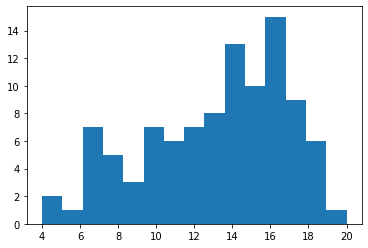

In [4]:
# Get all sensor responses and all the sensor positions
sns_response = pd.read_hdf(this_dir+file_name, 'MC/sns_response')
sns_positions = pd.read_hdf(this_dir+file_name, 'MC/sns_positions')
sns_response_sorted = sns_response.sort_values(by=['sensor_id'])
sipm_response = sns_response_sorted.loc[sns_response_sorted["sensor_id"] >999]
sipm_response = sipm_response.loc[sipm_response["time_bin"] >0]
pmt_response = sns_response_sorted.loc[sns_response_sorted["sensor_id"] < 60]
pmt_response = pmt_response.loc[pmt_response["time_bin"] >0]

pmt_time_binning = .025 # microseconds (25ns)
sipm_time_binning = 1.0 # microseconds

times_sipm = sipm_response.groupby(['event_id']).apply(lambda group: group['time_bin'].max() - group['time_bin'].min())
plt.hist(times_sipm*sipm_time_binning, bins=15)


In [5]:
dark_rate = 0.1 # MHz/mm^2 (inverse in microseconds)
# Dark count per sipm = event time x sipm size x dark count
sipm_size = 3.**2.
dark_count = times_sipm*sipm_size*dark_rate
dark_count

event_id
100    15.3
101     9.0
102    13.5
103    14.4
104     9.9
       ... 
195    14.4
196     9.9
197    10.8
198     8.1
199     9.0
Length: 100, dtype: float64

In [6]:
def Thresh_by_Event(group, args=dark_count):
    event = group.event_id.max()
    thresh = dark_count[event]
    return group[group.charge > thresh]

def Center_of_Event(sipm_response_in_event, sipm_positions):
    sensor_ids = sipm_response_in_event.sensor_id
    sensor_positions = sipm_positions.loc[sensor_ids]
    
    denominator = np.sum(sipm_response_in_event.charge)
    numerator = np.sum(sipm_response_in_event.set_index('sensor_id').charge*sensor_positions)

    return numerator/denominator

#thresh_sipm_response = sipm_response_by_event.apply(Thresh_by_Event).set_index('event_id').groupby('event_id')

In [7]:
sipm_response_by_event = sipm_response.groupby('event_id')
thresh_sipm_response = sipm_response_by_event.apply(Thresh_by_Event, args=(dark_count)).set_index('event_id').groupby('event_id')
#for _, grp in sipm_response_by_event:
#    print(grp.event_id.max())


In [8]:
thresh_sipm_response

In [9]:

sns_positions = pd.read_hdf(this_dir+file_name, 'MC/sns_positions')

# Sort to get the sipm positions
sns_pos_sorted = sns_positions.sort_values(by=['sensor_id'])
sipm_positions = sns_pos_sorted[sns_pos_sorted["sensor_name"].str.contains("SiPM")]

# Create separate dataframes for the sipm and pmt response
sns_response_sorted = sns_response.sort_values(by=['sensor_id'])
sipm_response = sns_response_sorted.loc[sns_response_sorted["sensor_id"] >999]
pmt_response = sns_response_sorted.loc[sns_response_sorted["sensor_id"] < 60]

# Summed pmt energy per event
response_perevent_pmt = pmt_response.groupby('event_id')
summed_charges_byevent_pmt = response_perevent_pmt.agg({"charge":"sum"})

# Summed sipm energy per event
response_perevent_sipm = sipm_response.groupby('event_id')
summed_charges_byevent_sipm = response_perevent_sipm.agg({"charge":"sum"})

# Position of the event(sipm with the max charge)
idx = sipm_response.groupby(['event_id'])['charge'].transform(max) == sipm_response['charge']
max_sipms = sipm_response[idx].sort_values('sensor_id').set_index('sensor_id')
new_max_sipm_positions = sipm_positions.set_index('sensor_id')
this = new_max_sipm_positions.loc[max_sipms.index.values.tolist()] 
event_map = pd.concat([max_sipms.loc[:,'event_id'],this.loc[:,['x','y','z']]], axis=1).set_index('event_id').sort_values(by='event_id')

pmt_map = pd.concat([summed_charges_byevent_pmt,event_map],axis=1)
sipm_map = pd.concat([summed_charges_byevent_sipm,event_map],axis=1)

# Make position a function of r
pmt_r = pmt_map.apply(lambda row: np.sqrt(row.x**2 + row.y**2), axis=1)
pmt_r = pmt_r.to_frame()
pmt_r = pmt_r.rename(columns = {pmt_r.columns[0]:'r'})
pmt_map = pd.concat([pmt_map, pmt_r],axis=1).sort_values(by='r')
sipm_r = sipm_map.apply(lambda row: np.sqrt(row.x**2 + row.y**2), axis=1)
sipm_r = sipm_r.to_frame()
sipm_r = sipm_r.rename(columns = {sipm_r.columns[0]:'r'})
sipm_map = pd.concat([sipm_map, sipm_r],axis=1).sort_values(by='r')

event_x = thresh_sipm_response.apply(lambda row: Center_of_Event(row,sipm_positions.set_index('sensor_id').x))
event_x = pd.DataFrame({'event_id':event_x.index,'x':event_x.values}).set_index('event_id')
event_y = thresh_sipm_response.apply(lambda row: Center_of_Event(row,sipm_positions.set_index('sensor_id').y))
event_y = pd.DataFrame({'event_id':event_y.index,'y':event_y.values}).set_index('event_id')

sipm_charge = sipm_response_by_event.agg({"charge":"sum"}).rename(columns={'charge':'sipm_charge'})
pmt_charge = pmt_response.groupby('event_id').agg({"charge":"sum"}).rename(columns={'charge':'pmt_charge'})
kr_map = pd.concat([pmt_charge,sipm_charge,event_x,event_y],axis=1)
kr_map

,pmt_charge,sipm_charge,x,y
event_id,,,,
100,7420,8192,140.906012,348.969094
101,7387,7937,181.833232,342.855508
102,6780,7270,459.191362,11.945248
103,7346,7877,-0.493579,-404.524478
104,7790,7809,236.413043,-142.134977
...,...,...,...,...
195,7898,8055,277.866460,-40.866460
196,7958,7969,-162.320607,-132.955382
197,7651,7947,156.484584,-285.859584


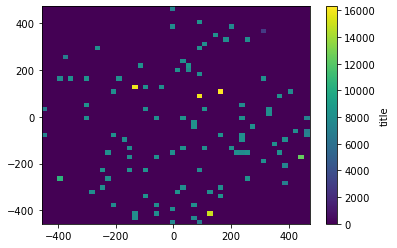

In [10]:
plt.hist2d(sipm_map.x, sipm_map.y, weights = sipm_map.charge, bins=[50,50])
plt.colorbar(label='title')

In [11]:
dark_rate = 0.1 # MHz/mm^2 (inverse in microseconds)
# Dark count per sipm = event time x sipm size x dark count
sipm_size = 3.**2.
dark_count = times_sipm*sipm_size*dark_rate
dark_rates = {1:90, 3:450, 6:1800}
#dark_rates[

In [12]:
s3mmp15mm = {'files': [this_dir+file_name], "size":3, "pitch":15, "dir": "s3mmp15mm"}
mcs = [s3mmp15mm]

pmt_time_binning = .025 # microseconds (25ns)
sipm_time_binning = 1.0 # microseconds
for mc in mcs:
    
    print("Looping in mcs")
    sipm_timing = pd.DataFrame()
    pmt_timing = pd.DataFrame()
    
    for file in mc["files"]:
        print("Looping files in mc")
        # Get all sensor responses and all the sensor positions
        sns_response = pd.read_hdf(file, 'MC/sns_response')
        sns_positions = pd.read_hdf(file, 'MC/sns_positions')
        sns_response_sorted = sns_response.sort_values(by=['sensor_id'])
        
        sipm_response = sns_response_sorted.loc[sns_response_sorted["sensor_id"] >999]
        sipm_response = sipm_response.loc[sipm_response["time_bin"] >0] 
        
        pmt_response = sns_response_sorted.loc[sns_response_sorted["sensor_id"] < 60]
        pmt_response = pmt_response.loc[pmt_response["time_bin"] >0]

        pmt_timing = pmt_timing.append(pmt_response.groupby(['event_id'])\
                        .apply(lambda group: group['time_bin'].max() - group['time_bin'].min()), ignore_index=True)
        sipm_timing = sipm_timing.append(sipm_response.groupby(['event_id'])\
                        .apply(lambda group: group['time_bin'].max() - group['time_bin'].min()), ignore_index=True)

        
        # Summed pmt energy per event
        response_perevent_pmt = pmt_response.groupby('event_id')
        summed_charges_byevent_pmt = response_perevent_pmt.agg({"charge":"sum"})

        # Summed sipm energy per event
        response_perevent_sipm = sipm_response.groupby('event_id')
        summed_charges_byevent_sipm = response_perevent_sipm.agg({"charge":"sum"})

        # Position of the event(sipm with the max charge)
        idx = sipm_response.groupby(['event_id'])['charge'].transform(max) == sipm_response['charge']
        print(idx)
        max_sipms = sipm_response[idx].sort_values('sensor_id').set_index('sensor_id')
        print(len(max_sipms.drop_duplicates()))
        new_max_sipm_positions = sipm_positions.set_index('sensor_id')
        this = new_max_sipm_positions.loc[max_sipms.index.values.tolist()]
        #event_map = pd.concat([max_sipms.loc[:,'event_id'],this.loc[:,['x','y','z']]], axis=1).set_index('event_id').sort_values(by='event_id') 
        event_map = this.loc[:,['x', 'y','z']]
        event_map['charge'] = summed_charges_byevent_sipm.charge
        
        #pmt_map = pmt_map.append(pd.concat([summed_charges_byevent_pmt,event_map],axis=1))
        #sipm_map = sipm_map.append(pd.concat([summed_charges_byevent_sipm,event_map],axis=1))
        #sipm_map = event_map
        #pmt_map = event_map
        #sipm_map['charge'] = summed_charges_byevent_sipm.charge.tolist()
        #pmt_map['charge'] = summed_charges_byevent_pmt.charge
        
    #dark_counts = dark_rates[mc['size']] * sipm_timing    
    #mc["pmt_times"] = pmt_timing
    #mc['sipm_times'] = sipm_timing
    
    #print(idx)
    #for i in sipm_map.sort_values('event_id').index:
    #    print(sipm_map.sort_values('event_id').charge[i], summed_charges_byevent_sipm.sort_values('event_id').charge[i])
    #print(len(summed_charges_byevent_sipm.index.tolist()), len(sipm_map.index.tolist()))
    #print(set(summed_charges_byevent_sipm.index.tolist()) - set(sipm_map.index.tolist()))
    

Looping in mcs
Looping files in mc
561782    False
872763    False
561781    False
275513    False
475747    False
          ...  
569950    False
162672    False
677592    False
283644    False
634419    False
Name: charge, Length: 355425, dtype: bool
104


(array([ 2.,  8.,  5., 10.,  6., 15., 23., 15., 15.,  1.]),
 array([ 4. ,  5.6,  7.2,  8.8, 10.4, 12. , 13.6, 15.2, 16.8, 18.4, 20. ]),
 <a list of 10 Patch objects>)

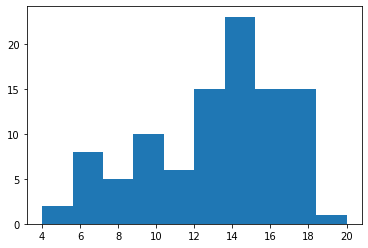

In [13]:
plt.hist(np.array(sipm_timing.T.values).flatten())

In [18]:
sipm_ave = np.array([])
np.append(sipm_ave, sipm_response.groupby('event_id').apply(lambda grp: np.mean(grp.charge)))

array([2.13667188, 2.28271498, 2.29554784, 2.15512996, 2.1607637 ,
       2.29124303, 2.29141779, 2.17081081, 2.15744797, 2.35588752,
       2.02724521, 2.3106346 , 2.0531545 , 2.09243048, 2.12840879,
       2.05397727, 2.08567018, 2.1242573 , 2.41054904, 2.06232221,
       2.16206897, 2.32907846, 2.3699422 , 2.21617852, 2.39504644,
       2.07465825, 2.39387097, 2.08409268, 2.4294849 , 2.21365167,
       2.25491313, 2.30621047, 2.18924731, 2.43421865, 2.15735099,
       2.21488062, 2.31203651, 2.20326727, 2.35446351, 2.05655992,
       2.34224907, 2.2647258 , 2.59436834, 2.3984052 , 2.12024987,
       2.09671387, 2.06391545, 2.11265076, 2.26192492, 2.11622403,
       2.27361854, 2.09950118, 2.29456681, 2.3112564 , 2.35618777,
       2.08414572, 2.04012112, 2.13838812, 2.18560088, 2.26872247,
       2.08898194, 2.19421861, 2.06673618, 2.10446571, 2.03394589,
       2.08927152, 2.20018738, 2.29014085, 2.08622449, 2.08740097,
       2.10638821, 2.06166625, 2.03544824, 2.05637755, 2.14023

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

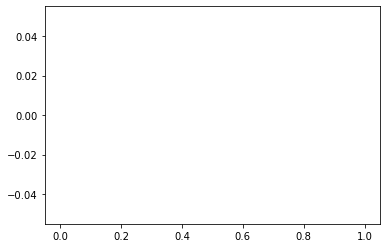

In [15]:
np.append(sipm_ave, sipm_response.charge.max())
plt.hist(sipm_ave)

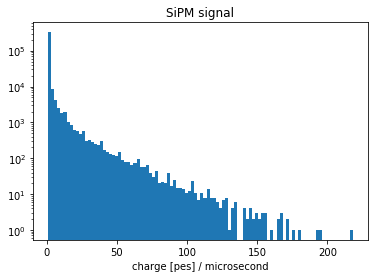

In [16]:
plt.hist(sipm_response.charge, bins=100)
plt.xlabel('charge [pes] / microsecond')
plt.title('SiPM signal')
plt.yscale('log')